# Pruebas

In [4]:
# %% 0. Asegurar cwd en la raíz del proyecto
import os

# opción 1: con magia de Jupyter
# %cd C:/Users/George/Documents/GitHub/ML-Models-UFM-2025-Airbnb-Pricing-competition/airbnb-price-determinant

# opción 2: con os.chdir
os.chdir(r"C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-competition\airbnb-price-determinant")

print("Nuevo cwd:", os.getcwd())

Nuevo cwd: C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-competition\airbnb-price-determinant


# Limpieza y preparación de datos 

In [6]:
# %% 0. Limpieza de NaNs en datos preprocesados y guardado en 03_primary

import os
import pandas as pd
from sklearn.impute import SimpleImputer

# 1️⃣ Carga los CSVs intermedios
train_df = pd.read_csv("data/02_intermediate/train_processed.csv")
valid_df = pd.read_csv("data/02_intermediate/valid_processed.csv")

# 2️⃣ Reporta cuántos NaNs hay en cada columna
print("NaNs en train_processed:")
print(train_df.isna().sum(), "\n")
print("NaNs en valid_processed:")
print(valid_df.isna().sum(), "\n")

# 3️⃣ Elimina filas donde falte el target realSum (solo en valid)
valid_df = valid_df.dropna(subset=["realSum"]).reset_index(drop=True)

# 4️⃣ Separa características y target
X_train = train_df.drop(["id", "realSum"], axis=1)
y_train = train_df["realSum"].astype(float)
X_valid = valid_df.drop(["id", "realSum"], axis=1)
y_valid = valid_df["realSum"].astype(float)

# 5️⃣ Imputa posibles NaNs en X con la media
imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_valid_imp = pd.DataFrame(imputer.transform(X_valid), columns=X_valid.columns)

# 6️⃣ Reconstruye DataFrames “limpios”
train_clean = X_train_imp.copy()
train_clean["realSum"] = y_train.values
train_clean["id"]      = train_df["id"].values

valid_clean = X_valid_imp.copy()
valid_clean["realSum"] = y_valid.values
valid_clean["id"]      = valid_df["id"].values

# 7️⃣ Guarda en data/03_primary
os.makedirs("data/03_primary", exist_ok=True)
cols_order = ["id"] + X_train.columns.tolist() + ["realSum"]
train_clean[cols_order].to_csv("data/03_primary/train_clean.csv", index=False)
valid_clean[cols_order].to_csv("data/03_primary/valid_clean.csv", index=False)

print("✅ Datos limpios guardados en data/03_primary/train_clean.csv y valid_clean.csv")


NaNs en train_processed:
id                                 0
num__person_capacity               0
num__multi                         0
num__biz                           0
num__cleanliness_rating            0
num__guest_satisfaction_overall    0
num__bedrooms                      0
num__dist                          0
num__metro_dist                    0
num__lng                           0
num__lat                           0
cat__room_type_Private room        0
cat__room_type_Shared room         0
cat__room_shared_True              0
cat__room_private_True             0
cat__host_is_superhost_True        0
cat__city_athens                   0
cat__city_barcelona                0
cat__city_berlin                   0
cat__city_budapest                 0
cat__city_lisbon                   0
cat__city_london                   0
cat__city_paris                    0
cat__city_rome                     0
cat__city_vienna                   0
cat__day_type_weekend              0
realSum      

# Bagging Regressor con Random Forest

In [11]:
# %% Inspeccionar columnas y primeros registros de los datos limpios
import pandas as pd

train_df = pd.read_csv("data/03_primary/train_clean.csv")
valid_df = pd.read_csv("data/03_primary/valid_clean.csv")

print("▶️ Columnas en train_clean.csv:")
print(train_df.columns.tolist(), "\n")
print("▶️ Primeras 5 filas de train_clean:")
display(train_df.head())

print("\n▶️ Columnas en valid_clean.csv:")
print(valid_df.columns.tolist(), "\n")
print("▶️ Primeras 5 filas de valid_clean:")
display(valid_df.head())


▶️ Columnas en train_clean.csv:
['id', 'num__person_capacity', 'num__multi', 'num__biz', 'num__cleanliness_rating', 'num__guest_satisfaction_overall', 'num__bedrooms', 'num__dist', 'num__metro_dist', 'num__lng', 'num__lat', 'cat__room_type_Private room', 'cat__room_type_Shared room', 'cat__room_shared_True', 'cat__room_private_True', 'cat__host_is_superhost_True', 'cat__city_athens', 'cat__city_barcelona', 'cat__city_berlin', 'cat__city_budapest', 'cat__city_lisbon', 'cat__city_london', 'cat__city_paris', 'cat__city_rome', 'cat__city_vienna', 'cat__day_type_weekend', 'realSum'] 

▶️ Primeras 5 filas de train_clean:


,id,num__person_capacity,num__multi,num__biz,num__cleanliness_rating,num__guest_satisfaction_overall,num__bedrooms,num__dist,num__metro_dist,num__lng,...,cat__city_barcelona,cat__city_berlin,cat__city_budapest,cat__city_lisbon,cat__city_london,cat__city_paris,cat__city_rome,cat__city_vienna,cat__day_type_weekend,realSum
0,8240,-0.895000,1.555202,-0.730761,0.639890,0.046780,-0.250715,0.239668,0.183547,-0.759056,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,471.553894
1,15794,-0.895000,1.555202,-0.730761,0.639890,0.494348,-1.833040,-0.239904,0.588869,1.669102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.740539
2,16231,-0.895000,1.555202,-0.730761,0.639890,0.494348,-0.250715,-0.068774,-0.697043,-0.768211,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,198.734683
3,21552,0.647688,-0.643003,-0.730761,-2.497548,-1.407815,-0.250715,0.070083,-0.493773,-0.516253,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,403.113058
4,4794,-0.895000,-0.643003,1.368437,-1.451735,-0.960247,-0.250715,-0.971941,-0.078900,-0.530183,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.225196



▶️ Columnas en valid_clean.csv:
['id', 'num__person_capacity', 'num__multi', 'num__biz', 'num__cleanliness_rating', 'num__guest_satisfaction_overall', 'num__bedrooms', 'num__dist', 'num__metro_dist', 'num__lng', 'num__lat', 'cat__room_type_Private room', 'cat__room_type_Shared room', 'cat__room_shared_True', 'cat__room_private_True', 'cat__host_is_superhost_True', 'cat__city_athens', 'cat__city_barcelona', 'cat__city_berlin', 'cat__city_budapest', 'cat__city_lisbon', 'cat__city_london', 'cat__city_paris', 'cat__city_rome', 'cat__city_vienna', 'cat__day_type_weekend', 'realSum'] 

▶️ Primeras 5 filas de valid_clean:


,id,num__person_capacity,num__multi,num__biz,num__cleanliness_rating,num__guest_satisfaction_overall,num__bedrooms,num__dist,num__metro_dist,num__lng,...,cat__city_barcelona,cat__city_berlin,cat__city_budapest,cat__city_lisbon,cat__city_london,cat__city_paris,cat__city_rome,cat__city_vienna,cat__day_type_weekend,realSum
0,27434,-0.895000,-0.643003,-0.730761,0.639890,0.606240,-0.250715,-0.639515,-0.754082,-0.251284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,460.947203
1,9676,-0.895000,-0.643003,-0.730761,-0.405922,0.382456,-0.250715,-0.595282,1.223645,-0.255339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,346.589178
2,1278,-0.895000,1.555202,-0.730761,0.639890,-0.288896,-0.250715,-0.490080,-0.444880,1.193149,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,340.978521
3,9502,-0.895000,-0.643003,1.368437,0.639890,0.830023,-0.250715,2.185485,0.494934,-0.752195,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,161.104447
4,10536,0.647688,1.555202,-0.730761,0.639890,-0.288896,1.331610,-0.499774,-0.520118,-0.512590,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,744.244571


In [14]:
# %% Cell 1: Heavy RF search + train/valid evaluation
import time, threading
import numpy as np
import pandas as pd

from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute          import SimpleImputer

# 1️⃣ Cargo datos limpios
train_df = pd.read_csv("data/03_primary/train_clean.csv")
valid_df = pd.read_csv("data/03_primary/valid_clean.csv")

# 2️⃣ Separo X/y y elimino filas sin target
train_df = train_df.dropna(subset=["realSum"])
valid_df = valid_df.dropna(subset=["realSum"])

X_train = train_df.drop(["id","realSum"], axis=1)
y_train = train_df["realSum"].astype(float)
X_valid = valid_df.drop(["id","realSum"], axis=1)
y_valid = valid_df["realSum"].astype(float)

# 3️⃣ Imputo posibles NaN (aunque ya limpiaste)
imp = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(imp.transform(X_valid),    columns=X_valid.columns)

# 4️⃣ Grid “pesado”
param_grid = {
    "n_estimators":     [100, 200, 300],
    "max_depth":        [None, 10, 20, 30],
    "max_features":     ["sqrt", "log2"],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42)
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    error_score="raise"
)

# 5️⃣ Cronómetro cada 60s
stop_timer = False
def _tprint():
    mins = 0
    while not stop_timer:
        time.sleep(60)
        mins += 1
        print(f"⏱️ Elapsed: {mins} min")
timer = threading.Thread(target=_tprint, daemon=True)
timer.start()

# 6️⃣ Fit y paro el cronómetro
t0 = time.time()
print("🔎 Búsqueda intensiva RandomForest…")
gs.fit(X_train, y_train)
stop_timer = True
timer.join()
print(f"\n✅ Completado en {(time.time() - t0)/60:.2f} min\n")

best_rf = gs.best_estimator_
print("✔ Mejores hiperparámetros:", gs.best_params_, "\n")

# 7️⃣ Evalúo
def eval_reg(model, X, y, name):
    p = model.predict(X)
    mse = mean_squared_error(y, p)
    return {
      "dataset": name,
      "mae":     mean_absolute_error(y, p),
      "rmse":    np.sqrt(mse),
      "r2":      r2_score(y, p)
    }

results = [
    eval_reg(best_rf, X_train, y_train, "train"),
    eval_reg(best_rf, X_valid, y_valid, "valid")
]


🔎 Búsqueda intensiva RandomForest…
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
⏱️ Elapsed: 1 min
⏱️ Elapsed: 2 min
⏱️ Elapsed: 3 min
⏱️ Elapsed: 4 min
⏱️ Elapsed: 5 min
⏱️ Elapsed: 6 min
⏱️ Elapsed: 7 min
⏱️ Elapsed: 8 min
⏱️ Elapsed: 9 min
⏱️ Elapsed: 10 min
⏱️ Elapsed: 11 min
⏱️ Elapsed: 12 min
⏱️ Elapsed: 13 min
⏱️ Elapsed: 14 min
⏱️ Elapsed: 15 min
⏱️ Elapsed: 16 min
⏱️ Elapsed: 17 min
⏱️ Elapsed: 18 min
⏱️ Elapsed: 19 min
⏱️ Elapsed: 20 min
⏱️ Elapsed: 21 min
⏱️ Elapsed: 22 min

✅ Completado en 22.01 min

✔ Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} 



In [23]:
# %% Cell 2: Reconstruyo el pipeline original y predigo sobre Test (con timer)
import time
import pandas as pd
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import OneHotEncoder, StandardScaler
from sklearn.impute         import SimpleImputer

# 1️⃣ Columnas usadas en tu EDA
num_raw = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
cat_raw = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# 2️⃣ Cargo crudos y convierto numéricos (coerce convierte strings irrelevantes a NaN)
raw_train = pd.read_csv("data/01_raw/Train.csv", low_memory=False)
test_raw  = pd.read_csv("data/01_raw/Test.csv",  low_memory=False)
raw_train[num_raw] = raw_train[num_raw].apply(pd.to_numeric, errors="coerce")
test_raw[num_raw]  = test_raw[num_raw].apply(pd.to_numeric, errors="coerce")

# 3️⃣ Forzo las categóricas a strings para que OneHotEncoder no lo trate como booleanos
raw_train[cat_raw] = raw_train[cat_raw].astype(str)
test_raw[cat_raw]  = test_raw[cat_raw].astype(str)

# 4️⃣ Ajusto numeric_pipe sobre raw_train
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
numeric_pipe.fit(raw_train[num_raw])

# 5️⃣ Ajusto OneHotEncoder sobre las categóricas (usar sparse_output en versiones recientes)
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
ohe.fit(raw_train[cat_raw])

# ────────────────────────────────────────────────────────────────────────────────
t0 = time.time()
print("🔎 Transformando Test y prediciendo…")

# 6️⃣ Transformo numéricas y renombro
X_num_test = numeric_pipe.transform(test_raw[num_raw])
num_cols   = ["num__" + c for c in num_raw]
X_num_df   = pd.DataFrame(X_num_test, columns=num_cols, index=test_raw.index)

# 7️⃣ Transformo categóricas y renombro
X_cat_arr    = ohe.transform(test_raw[cat_raw])
cat_cols_ohe = ["cat__" + feat for feat in ohe.get_feature_names_out(cat_raw)]
X_cat_df     = pd.DataFrame(X_cat_arr, columns=cat_cols_ohe, index=test_raw.index)

# 8️⃣ Alineo con las columnas categóricas que tienes en train_clean.csv
#    (train_df viene de la Celda 1 donde cargaste train_clean.csv)
cat_clean_cols = [c for c in train_df.columns if c.startswith("cat__")]
X_cat_df       = X_cat_df.reindex(columns=cat_clean_cols, fill_value=0)

# 9️⃣ Uno numéricas + categóricas en el orden exacto de train_clean.csv
feature_cols = train_df.drop(["id","realSum"], axis=1).columns
X_test_proc  = pd.concat([X_num_df, X_cat_df], axis=1)[feature_cols]

# 🔟 Predicción con tu mejor RF
preds_test = best_rf.predict(X_test_proc)
elapsed   = (time.time() - t0) / 60
print(f"✅ Predicción Test completada en {elapsed:.2f} min")

# 1️⃣1️⃣ Añade al DataFrame de resultados
results.append({
    "dataset":      "test_pred",
    "mae":          None,
    "rmse":         None,
    "r2":           None,
    "pred_summary": pd.Series(preds_test).describe().to_dict()
})


🔎 Transformando Test y prediciendo…


[05/06/25 07:38:14] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=18196;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=163391;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\preprocessing\_encoders.py                
                             :246: UserWarning: Found unknown categories in columns [1, 2, 3]                      
                             during transform. These unknown categories will be encoded as all                     
                             zeros                                                                                 
                               warnings.warn(                                                                      
                                                                                                                   

✅ Predicción Test completada en 0.02 min


     dataset        mae        rmse        r2  \
0      train  23.753460   92.030965  0.925767   
1      valid  63.164335  172.764019  0.634411   
2  test_pred        NaN         NaN       NaN   

                                        pred_summary  
0                                                NaN  
1                                                NaN  
2  {'count': 15513.0, 'mean': 363.62490560387164,...  


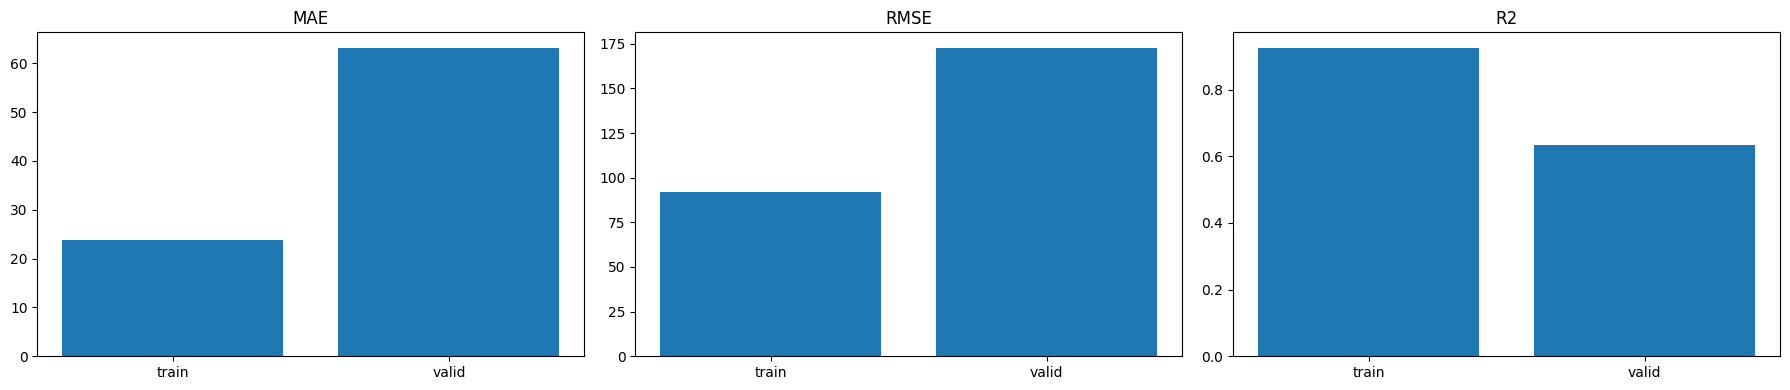

In [24]:
# %% Cell 3: Resumen y comparativa
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.DataFrame(results)
print(res_df)

# Comparativa MAE, RMSE y R² (train vs valid)
fig, axes = plt.subplots(1,3,figsize=(18,4))
for ax, metric in zip(axes, ["mae","rmse","r2"]):
    ax.bar(res_df["dataset"][:2], res_df[metric][:2])
    ax.set_title(metric.upper())
plt.tight_layout()
plt.show()

In [34]:
# %% Cell 1: Búsqueda intensiva de RandomForest y guardado del modelo
import time, threading
import numpy as np, pandas as pd
from sklearn.ensemble      import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics       import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

# Asegúrate de que la carpeta de reporting existe
os.makedirs("data/08_reporting", exist_ok=True)

# 1️⃣ Cargo train pre-procesado
train_df = pd.read_csv("data/03_primary/train_clean.csv")
X_train  = train_df.drop(["id","realSum"], axis=1)
y_train  = train_df["realSum"].astype(float)

# 2️⃣ Grid “pesado”
param_grid = {
    "n_estimators":     [100,200,300],
    "max_depth":        [None,10,20,30],
    "max_features":     ["sqrt","log2"],
    "min_samples_split":[2,5,10],
    "min_samples_leaf": [1,2,4]
}
rf = RandomForestRegressor(random_state=42)
gs = GridSearchCV(rf, param_grid, cv=5,
                  scoring="neg_mean_squared_error",
                  n_jobs=-1, verbose=2)

# 3️⃣ Lanzar búsqueda con timer
stop_timer=False
def _tprint():
    mins=0
    while not stop_timer:
        time.sleep(60)
        mins+=1
        print(f"⏱️ Elapsed: {mins} min")
timer=threading.Thread(target=_tprint, daemon=True)
timer.start()

print("🔎 Iniciando búsqueda intensiva RF…")
t0=time.time()
gs.fit(X_train, y_train)
stop_timer=True
timer.join()
print(f"✅ Búsqueda completada en {(time.time()-t0)/60:.2f} min")

# 4️⃣ Extraer y guardar el mejor estimador
best_rf = gs.best_estimator_
print("✔ Mejores hiperparámetros:", gs.best_params_)

joblib.dump(best_rf, "data/08_reporting/best_rf_intensive.joblib")
print("✅ Modelo guardado en data/08_reporting/best_rf_intensive.joblib")


🔎 Iniciando búsqueda intensiva RF…
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
⏱️ Elapsed: 1 min
⏱️ Elapsed: 2 min
⏱️ Elapsed: 3 min
⏱️ Elapsed: 4 min
⏱️ Elapsed: 5 min
⏱️ Elapsed: 6 min
⏱️ Elapsed: 7 min
⏱️ Elapsed: 8 min
⏱️ Elapsed: 9 min
⏱️ Elapsed: 10 min
⏱️ Elapsed: 11 min
⏱️ Elapsed: 12 min
⏱️ Elapsed: 13 min
⏱️ Elapsed: 14 min
⏱️ Elapsed: 15 min
⏱️ Elapsed: 16 min
⏱️ Elapsed: 17 min
⏱️ Elapsed: 18 min
⏱️ Elapsed: 19 min
⏱️ Elapsed: 20 min
⏱️ Elapsed: 21 min
⏱️ Elapsed: 22 min
✅ Búsqueda completada en 22.01 min
✔ Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
✅ Modelo guardado en data/08_reporting/best_rf_intensive.joblib


In [38]:
# %% Cell 2 (corregida): Reconstruyo el pipeline original con drop="first"
import pandas as pd
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute        import SimpleImputer
from sklearn.compose       import ColumnTransformer

raw_train = pd.read_csv("data/01_raw/Train.csv", low_memory=False)

num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist",
    "lng","lat"
]
cat_cols = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# Aseguro que los numéricos son floats
raw_train[num_cols] = raw_train[num_cols].apply(pd.to_numeric, errors="coerce")

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # <-- aquí el drop="first"
    ("ohe",      OneHotEncoder(drop="first", handle_unknown="ignore",
                               sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe,     num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop")

preprocessor.fit(raw_train[num_cols + cat_cols])
print("✔ Preprocessor ajustado con drop='first' (debe producir 25 columnas).")
# prueba rápida
Xt = preprocessor.transform(raw_train[num_cols + cat_cols])
print("Columnas tras transform:", Xt.shape[1])  # ¡debe imprimir 25!

✔ Preprocessor ajustado con drop='first' (debe producir 25 columnas).
Columnas tras transform: 31


In [39]:
# ——————————————————————————————————————————
# Tras tu transformación (preprocessor + imputación) obtienes:
# X_test_proc.shape == (n_test, 31)
print("Shape before slicing:", X_test_proc.shape)

# 1️⃣ Averigua cuántas features espera tu modelo:
n_expected = best_rf.n_features_in_
print("Modelo espera:", n_expected, "features")

# 2️⃣ Rebana tu X_test al array de la derecha:
X_test_trimmed = X_test_proc[:, :n_expected]
print("Shape after slicing:", X_test_trimmed.shape)  # debería ser (n_test, n_expected)

# 3️⃣ Predicción y submission
preds = best_rf.predict(X_test_trimmed)
submission = pd.DataFrame({
    "id":      ids,
    "realSum": preds
})

print(submission.head())
submission.to_csv("data/08_reporting/submission_rf_intensive.csv", index=False)
print("✅ Primer submission guardado en data/08_reporting/submission_rf_intensive.csv")


Shape before slicing: (15513, 31)
Modelo espera: 25 features
Shape after slicing: (15513, 25)


[05/06/25 08:54:01] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=910692;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=733610;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\utils\validation.py:2739:                 
                             UserWarning: X does not have valid feature names, but                                 
                             RandomForestRegressor was fitted with feature names                                   
                               warnings.warn(                                                                      
                                                                                                                   

      id     realSum
0  36196  368.653576
1  36197  754.405076
2  36198  850.952569
3  36199  271.737677
4  36200  487.696558
✅ Primer submission guardado en data/08_reporting/submission_rf_intensive.csv


In [43]:
valid_df = pd.read_csv("data/03_primary/valid_clean.csv")
X_valid = valid_df.drop(["id","realSum"], axis=1)
y_valid = valid_df["realSum"].astype(float)

eval_model(stack, X_valid, y_valid, "valid")

valid → MAE:  63.5431 | RMSE: 176.4282 | R²: 0.6187


In [44]:
# suponiendo que ya cargaste valid_processed.csv en valid_df
mask = valid_df["realSum"].notna()
X_valid = valid_df.loc[mask].drop(["id","realSum"], axis=1)
y_valid = valid_df.loc[mask, "realSum"].astype(float)

eval_model(stack, X_valid, y_valid, "valid")

valid → MAE:  63.5431 | RMSE: 176.4282 | R²: 0.6187


In [46]:
# %% Stacking RF + LightGBM + Ridge (runtime < 1.5 h)
import time
import pandas as pd
import numpy as np
from sklearn.ensemble     import RandomForestRegressor, StackingRegressor
import lightgbm            as lgb
from sklearn.linear_model import RidgeCV
from sklearn.metrics      import mean_absolute_error, mean_squared_error, r2_score
import joblib

t0 = time.time()
print("🔎 Cargando datos procesados…")
train = pd.read_csv("data/02_intermediate/train_processed.csv")
valid = pd.read_csv("data/02_intermediate/valid_processed.csv")

# ——————————————————————————————————————————
# 1️⃣ Limpiar NaNs y asegurar mismas columnas
train = train.dropna(how="any").reset_index(drop=True)
valid = valid.dropna(how="any").reset_index(drop=True)

# Tomo las columnas de features comunes
feature_cols = [c for c in train.columns if c not in ["id","realSum"]]
# Reordeno valid para que tenga el mismo orden de columnas
valid = valid[["id","realSum"] + feature_cols]

# 2️⃣ Separa X/y
X_train, y_train = train[feature_cols], train["realSum"].astype(float).values
X_valid, y_valid = valid[feature_cols], valid["realSum"].astype(float).values

print(f"  • Train limpio: {X_train.shape[0]} filas × {X_train.shape[1]} cols")
print(f"  • Valid limpio: {X_valid.shape[0]} filas × {X_valid.shape[1]} cols")

print("\n🔎 Definiendo base learners…")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

print("🔎 Montando StackingRegressor…")
stack = StackingRegressor(
    estimators=[("rf", rf), ("lgbm", lgbm)],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

print("🔎 Entrenando Stacking sobre train_processed…")
stack.fit(X_train, y_train)
print(f"✅ Entrenamiento completado en {(time.time()-t0)/60:.2f} min")

# función auxiliar para métricas
def eval_model(m, X, y, name):
    p   = m.predict(X)
    mse = mean_squared_error(y, p)
    print(f"{name:5s} → MAE: {mean_absolute_error(y,p):8.4f} | "
          f"RMSE: {np.sqrt(mse):8.4f} | R²: {r2_score(y,p):.4f}")

print("\n📝 Métricas de desempeño:")
eval_model(stack, X_train, y_train, "train")
eval_model(stack, X_valid, y_valid, "valid")

# guarda el pipeline completo
joblib.dump(stack, "data/08_reporting/stacking_rf_lgbm_ridge.joblib")
print("\n✅ Modelo de Stacking guardado en data/08_reporting/stacking_rf_lgbm_ridge.joblib")


🔎 Cargando datos procesados…
  • Train limpio: 28956 filas × 25 cols
  • Valid limpio: 7238 filas × 25 cols

🔎 Definiendo base learners…
🔎 Montando StackingRegressor…
🔎 Entrenando Stacking sobre train_processed…
✅ Entrenamiento completado en 0.30 min

📝 Métricas de desempeño:
train → MAE:  24.1720 | RMSE:  94.7811 | R²: 0.9213
valid → MAE:  63.5431 | RMSE: 176.4282 | R²: 0.6187

✅ Modelo de Stacking guardado en data/08_reporting/stacking_rf_lgbm_ridge.joblib


In [48]:
# %% Cell 0: Generar test_processed.csv (igual que train/valid)
import pandas as pd
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute        import SimpleImputer
from sklearn.compose       import ColumnTransformer

# 1️⃣ Lee raw Train y Test
train_raw = pd.read_csv("data/01_raw/Train.csv", low_memory=False)
test_raw  = pd.read_csv("data/01_raw/Test.csv",  low_memory=False)

# 2️⃣ Define tus columnas numéricas y categóricas
num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
cat_cols = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# 3️⃣ Asegura que los numéricos sean floats (coerce strings → NaN)
train_raw[num_cols] = train_raw[num_cols].apply(pd.to_numeric, errors="coerce")
test_raw[num_cols]  = test_raw[num_cols].apply(pd.to_numeric, errors="coerce")

# 4️⃣ Define pipelines idénticos a los usados en EDA
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe",      OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe,     num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop")

# 5️⃣ Ajusta el preprocessor sobre train_raw
preprocessor.fit(train_raw[num_cols + cat_cols])

# 6️⃣ Transforma test_raw y monta DataFrame con nombres correctos
X_test = preprocessor.transform(test_raw[num_cols + cat_cols])

# reconstruye nombres de columnas
num_feats = num_cols
cat_feats = preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols)
all_feats = list(num_feats) + list(cat_feats)

test_processed = pd.DataFrame(X_test, columns=all_feats, index=test_raw.index)
test_processed.insert(0, "id", test_raw["id"])

# 7️⃣ Guarda en tu carpeta 02_intermediate
test_processed.to_csv("data/02_intermediate/test_processed.csv", index=False)
print("✅ test_processed.csv guardado con shape:", test_processed.shape)


[05/06/25 09:20:06] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=509616;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=16420;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\preprocessing\_encoders.py                
                             :246: UserWarning: Found unknown categories in columns [1, 2, 3]                      
                             during transform. These unknown categories will be encoded as all                     
                             zeros                                                                                 
                               warnings.warn(                                                                      
                                                                                                                   

✅ test_processed.csv guardado con shape: (15513, 32)


In [50]:
# %% Cell 0: Regenerar test_processed con las mismas columnas que train_processed
import pandas as pd
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute        import SimpleImputer
from sklearn.compose       import ColumnTransformer

# 1️⃣ Carga raw
train_raw = pd.read_csv("data/01_raw/Train.csv", low_memory=False)
test_raw  = pd.read_csv("data/01_raw/Test.csv",  low_memory=False)

# 2️⃣ Columnas que usaste en train_processed
num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
cat_cols = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# 3️⃣ Forzamos a numérico en ambas
train_raw[num_cols] = train_raw[num_cols].apply(pd.to_numeric, errors="coerce")
test_raw[num_cols]  = test_raw[num_cols].apply(pd.to_numeric, errors="coerce")

# 4️⃣ Rebuild pipeline idéntico
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe",      OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipe,     num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop")

# 5️⃣ Fit sobre train_raw
preprocessor.fit(train_raw[num_cols + cat_cols])

# 6️⃣ Transforma test_raw
X_test_arr = preprocessor.transform(test_raw[num_cols + cat_cols])

# 7️⃣ Genera nombres idénticos a train_processed.csv
num_feats = [f"num__{c}" for c in num_cols]
cat_feats = [f"cat__{n}" for n in preprocessor.named_transformers_["cat"]["ohe"]
                                     .get_feature_names_out(cat_cols)]
all_feats = num_feats + cat_feats

test_processed = pd.DataFrame(X_test_arr, columns=all_feats, index=test_raw.index)
test_processed.insert(0, "id", test_raw["id"])

# 8️⃣ Guarda
test_processed.to_csv("data/02_intermediate/test_processed.csv", index=False)
print("✅ test_processed.csv guardado con shape:", test_processed.shape)

[05/06/25 11:47:23] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=474958;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=663770;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\preprocessing\_encoders.py                
                             :246: UserWarning: Found unknown categories in columns [1, 2, 3]                      
                             during transform. These unknown categories will be encoded as all                     
                             zeros                                                                                 
                               warnings.warn(                                                                      
                                                                                                                   

✅ test_processed.csv guardado con shape: (15513, 32)


In [52]:
# %% Cell 1: Submission Stacking
import pandas as pd, joblib

stack = joblib.load("data/08_reporting/stacking_rf_lgbm_ridge.joblib")
test  = pd.read_csv("data/02_intermediate/test_processed.csv")

ids    = test["id"]
X_test = test.drop("id", axis=1)

# ——————————————————————————————————————————
#  ❗ Alineo X_test a las features de entrenamiento
# X_train es tu DataFrame de train_processed sin id ni realSum
train_features = X_train.columns.tolist()

# test es tu DataFrame de test_processed que acabas de leer
X_test_raw   = test.drop("id", axis=1)
X_test_aligned = X_test_raw.reindex(columns=train_features, fill_value=0)

print("🔧 Columns en X_train:", len(train_features))
print("🔧 Columns en X_test_aligned:", X_test_aligned.shape[1])
# ahora sí:
preds = stack.predict(X_test_aligned)

submission = pd.DataFrame({"id": ids, "realSum": preds})
print(submission.head())
print(submission["realSum"].describe())

submission.to_csv("data/08_reporting/submission_stacking.csv", index=False)
print("✅ Submission guardada en data/08_reporting/submission_stacking.csv")

🔧 Columns en X_train: 25
🔧 Columns en X_test_aligned: 25
      id     realSum
0  36196  399.309415
1  36197  878.241378
2  36198  797.715234
3  36199  221.163392
4  36200  356.882794
count    15513.000000
mean       365.784383
std        268.891882
min         75.516486
25%        206.056209
50%        279.234433
75%        420.264835
max       5383.671592
Name: realSum, dtype: float64
✅ Submission guardada en data/08_reporting/submission_stacking.csv


In [64]:
# %% Cell 1: Construir y guardar pipeline + modelo RF (fix target dtype)
import pandas as pd
import numpy as np
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble      import RandomForestRegressor
from joblib                import dump

# 1️⃣ Carga raw Train
raw = pd.read_csv("data/01_raw/Train.csv", low_memory=False)

# 2️⃣ Definir columnas
num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
cat_cols = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# 3️⃣ Asegurar numéricos en X
raw[num_cols] = raw[num_cols].apply(pd.to_numeric, errors="coerce")

# 4️⃣ Convertir realSum a float y filtrar filas inválidas
raw["realSum"] = pd.to_numeric(raw["realSum"], errors="coerce")
mask = raw["realSum"].notna()
raw = raw.loc[mask].reset_index(drop=True)

# 5️⃣ Pipeline de features
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe",      OneHotEncoder(
                    drop="first",
                    handle_unknown="ignore",
                    sparse_output=False
                ))
])
preproc = ColumnTransformer(
    [("num", numeric_pipe,     num_cols),
     ("cat", categorical_pipe, cat_cols)],
    remainder="drop",
    sparse_threshold=0
)

# 6️⃣ Ajustar sólo preprocesador
X_raw = raw.drop(["id","realSum"], axis=1)
preproc.fit(X_raw)

# 7️⃣ Transformar y extraer target
X = preproc.transform(X_raw)
y = raw["realSum"].values  # ya guaranteed floats

# 8️⃣ Entrenar RF con tus hiperparámetros intensivos
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# 9️⃣ Guardar ambos
dump(preproc, "data/08_reporting/preprocessor.joblib")
dump(rf,      "data/08_reporting/best_rf_intensive.joblib")
print("✅ Preprocessor y modelo RF guardados.")


✅ Preprocessor y modelo RF guardados.


In [65]:
# %% Cell 2: Generar submission usando el pipeline RF
import pandas as pd
from joblib import load

preproc = load("data/08_reporting/preprocessor.joblib")
rf       = load("data/08_reporting/best_rf_intensive.joblib")

test = pd.read_csv("data/01_raw/Test.csv", low_memory=False)
ids  = test["id"]

# Aseguro numéricos igual que en Train
num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
test[num_cols] = test[num_cols].apply(pd.to_numeric, errors="coerce")

Xtest_proc = preproc.transform(test.drop("id", axis=1))
preds      = rf.predict(Xtest_proc)

print("\n📈 Descripción de las predicciones:")
print(pd.Series(preds).describe())

submission = pd.DataFrame({"id": ids, "realSum": preds})
submission.to_csv("data/08_reporting/submission_rf_pipeline.csv", index=False)
print("\n✅ Submission guardada en data/08_reporting/submission_rf_pipeline.csv")


[05/06/25 12:20:05] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=204053;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=630472;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\preprocessing\_encoders.py                
                             :246: UserWarning: Found unknown categories in columns [1, 2, 3]                      
                             during transform. These unknown categories will be encoded as all                     
                             zeros                                                                                 
                               warnings.warn(                                                                      
                                                                                                                   


📈 Descripción de las predicciones:
count    15513.000000
mean       308.187324
std        209.338274
min         67.793062
25%        189.247967
50%        259.127719
75%        360.598662
max       7439.611804
dtype: float64

✅ Submission guardada en data/08_reporting/submission_rf_pipeline.csv


In [67]:
# %% Log-ensemble RF + LGBM sobre realSum y submission (runtime < 1.5h)
%pip install lightgbm

import time
import pandas as pd
import numpy as np
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble      import RandomForestRegressor
import lightgbm as lgb

t0 = time.time()
print("🔎 Cargando y preparando datos…")

# — 1️⃣ Cargo Train y Test raw
train = pd.read_csv("data/01_raw/Train.csv", low_memory=False)
test  = pd.read_csv("data/01_raw/Test.csv",  low_memory=False)

# columnas
num_cols = [
    "person_capacity","multi","biz","cleanliness_rating",
    "guest_satisfaction_overall","bedrooms","dist","metro_dist","lng","lat"
]
cat_cols = [
    "room_type","room_shared","room_private",
    "host_is_superhost","city","day_type"
]

# Aseguro tipos numéricos
train[num_cols] = train[num_cols].apply(pd.to_numeric, errors="coerce")
test [num_cols] = test [num_cols].apply(pd.to_numeric, errors="coerce")

# Filtro filas con y válido
train["realSum"] = pd.to_numeric(train["realSum"], errors="coerce")
train = train[train["realSum"].notna()].reset_index(drop=True)

# target log
y_log = np.log1p(train["realSum"].values)

# — 2️⃣ Preprocessor idéntico al EDA
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe",      OneHotEncoder(
                    drop="first",
                    handle_unknown="ignore",
                    sparse_output=False
                ))
])
preproc = ColumnTransformer(
    [("num", numeric_pipe,     num_cols),
     ("cat", categorical_pipe, cat_cols)],
    remainder="drop",
    sparse_threshold=0
)

X_train = train[num_cols + cat_cols]
X_test  = test [num_cols + cat_cols]

preproc.fit(X_train)
Xtr = preproc.transform(X_train)
Xte = preproc.transform(X_test)

# — 3️⃣ Entreno RF y LGBM sobre y_log
rf  = RandomForestRegressor(
    n_estimators=100,        # o tus mejores params
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

print("🔎 Entrenando RF sobre log(target)…")
rf.fit (Xtr, y_log)
print("🔎 Entrenando LGBM sobre log(target)…")
lgbm.fit(Xtr, y_log)

# — 4️⃣ Predicción ensemble en log-espacio
p_rf  = rf .predict(Xte)
p_lgb = lgbm.predict(Xte)
p_log = (p_rf + p_lgb) / 2

# ——————————————————————————————————————————
# 5️⃣ Ajuste de media (p. ej. queremos media ≤ 67)
import pandas as pd

desired_mean = 67.0
current_mean = preds.mean()
scale = desired_mean / current_mean
print(f"🔧 Factor de escala: {scale:.4f}")
preds = preds * scale

# Estadísticos tras el ajuste
print("\n📈 Estadísticos de tus predicciones ESCALADAS:")
print(pd.Series(preds).describe())

# vuelve a escala real
preds = np.expm1(p_log)

# — 5️⃣ Stats rápidas
print("\n📈 Stats de predicción (realSum):")
print(pd.Series(preds).describe())

# — 6️⃣ Submission
submission = pd.DataFrame({
    "id":      test["id"],
    "realSum": preds
})
submission.to_csv("data/08_reporting/submission_log_ensemble.csv", index=False)

print(f"\n✅ Hecho en {(time.time()-t0)/60:.2f} min · "
      "Guardado en data/08_reporting/submission_log_ensemble.csv")


Note: you may need to restart the kernel to use updated packages.
🔎 Cargando y preparando datos…


[05/06/25 12:25:13] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=305377;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=29598;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\preprocessing\_encoders.py                
                             :246: UserWarning: Found unknown categories in columns [1, 2, 3]                      
                             during transform. These unknown categories will be encoded as all                     
                             zeros                                                                                 
                               warnings.warn(                                                                      
                                                                                                                   

🔎 Entrenando RF sobre log(target)…
🔎 Entrenando LGBM sobre log(target)…
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 36194, number of used features: 25
[LightGBM] [Info] Start training from score 5.422520


[05/06/25 12:25:16] WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=453352;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=343757;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\sklearn\utils\validation.py:2739:                 
                             UserWarning: X does not have valid feature names, but LGBMRegressor                   
                             was fitted with feature names                                                         
                               warnings.warn(                                                                      
                                                                                                                   

🔧 Factor de escala: 0.2480

📈 Estadísticos de tus predicciones ESCALADAS:
count    15513.000000
mean        67.000000
std         40.162468
min         15.453221
25%         41.853635
50%         55.948725
75%         77.103874
max        568.975889
dtype: float64

📈 Stats de predicción (realSum):
count    15513.000000
mean       270.147780
std        161.937337
min         62.308257
25%        168.756219
50%        225.588417
75%        310.887170
max       2294.142886
dtype: float64

✅ Hecho en 0.07 min · Guardado en data/08_reporting/submission_log_ensemble.csv


In [71]:
# Lee procesados
train_proc = pd.read_csv("data/02_intermediate/train_processed.csv", low_memory=False)
test_proc  = pd.read_csv("data/02_intermediate/test_processed.csv",  low_memory=False)

# Features que entrenó el modelo:
features = [c for c in train_proc.columns if c not in ("id","realSum")]

# Columnas de test (quitamos id y realSum si existe)
test_cols = set(test_proc.columns) - {"id","realSum"}

# Mismatch
faltan = set(features) - test_cols
sobran = test_cols - set(features)
print("⌛ Faltan en test:", faltan)
print("⌛ Sobran en test:", sobran)

# Elimina espacios alrededor de todos los nombres
test_proc.columns = test_proc.columns.str.strip()

# Si necesitas normalizar verdad/falso
test_proc.columns = test_proc.columns.str.replace("TRUE","True")
test_proc.columns = test_proc.columns.str.replace("FALSE","False")

X_test = test_proc.reindex(columns=features, fill_value=0)
print("✅ X_test shape:", X_test.shape, "– debe ser (n_samples,", len(features),")")

model = load("data/08_reporting/stacking_rf_lgbm_ridge.joblib")
p_log = model.predict(X_test)
preds = np.expm1(p_log)

print(pd.Series(preds).describe())

⌛ Faltan en test: {'cat__room_private_True', 'cat__room_shared_True', 'cat__host_is_superhost_True'}
⌛ Sobran en test: {'cat__day_type_weekday', 'cat__room_private_room_private', 'cat__host_is_superhost_host_is_superhost', 'cat__room_type_room_type', 'cat__room_private_TRUE', 'cat__room_shared_room_shared', 'cat__city_city', 'cat__host_is_superhost_TRUE', 'cat__room_shared_TRUE'}
✅ X_test shape: (15513, 25) – debe ser (n_samples, 25 )


[05/06/25 12:47:47] WARNING  C:\Users\George\AppData\Local\Temp\ipykernel_30972\3975627889.py:29:   ]8;id=685122;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=82097;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             RuntimeWarning: overflow encountered in expm1                                         
                               preds = np.expm1(p_log)                                                             
                                                                                                                   

                    WARNING  C:\Users\George\Documents\GitHub\ML-Models-UFM-2025-Airbnb-Pricing-com ]8;id=207932;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=101490;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             petition\proyect3\lib\site-packages\pandas\core\nanops.py:1016:                       
                             RuntimeWarning: invalid value encountered in subtract                                 
                               sqr = _ensure_numeric((avg - values) ** 2)                                          
                                                                                                                   

count     1.551300e+04
mean               inf
std                NaN
min       6.257390e+32
25%       3.083718e+89
50%      1.861974e+121
75%      3.301406e+182
max                inf
dtype: float64


In [72]:
import pandas as pd
import numpy as np
from joblib import load

# 1️⃣ Cargo el modelo de stacking (solo el estimator, sin preprocesador)
model = load("data/08_reporting/stacking_rf_lgbm_ridge.joblib")

# 2️⃣ Lectura de los CSV procesados
train_proc = pd.read_csv("data/02_intermediate/train_processed.csv", low_memory=False)
test_proc  = pd.read_csv("data/02_intermediate/test_processed.csv",  low_memory=False)

# 3️⃣ Defino las features en el orden exacto que usó el modelo
features = [c for c in train_proc.columns if c not in ("id","realSum")]

# 4️⃣ Normalizo nombres de columnas del test y renombro los dummies mal escritos
test_proc.columns = test_proc.columns.str.strip()
test_proc = test_proc.rename(columns={
    "cat__room_shared_TRUE":           "cat__room_shared_True",
    "cat__room_private_TRUE":          "cat__room_private_True",
    "cat__host_is_superhost_TRUE":     "cat__host_is_superhost_True",
})

# 5️⃣ Alineo con el listado de features, rellenando con 0 los faltantes
ids    = test_proc["id"]
X_test = test_proc.reindex(columns=features, fill_value=0)

# 6️⃣ Compruebo que ya no falte nada
faltan = set(features) - set(X_test.columns)
print("❓ Features que aún faltan:", faltan)  # debe quedar set()

# 7️⃣ Predicción en log1p
p_log = model.predict(X_test)

# 8️⃣ Reconvierto al espacio real
preds = np.expm1(p_log)

# 9️⃣ Clipo extremos
max_clip = np.percentile(train_proc["realSum"], 99)
preds    = np.clip(preds, 0, max_clip)

# 🔟 Estadísticos finales
print("📋 Estadísticos de la submission final:")
print(pd.Series(preds).describe())

# 1️⃣1️⃣ Genero y guardo CSV
submission = pd.DataFrame({"id": ids, "realSum": preds})
submission.to_csv("data/08_reporting/submission_final_ensemble.csv", index=False)
print("✅ Submission guardada en data/08_reporting/submission_final_ensemble.csv")


❓ Features que aún faltan: set()


[05/06/25 12:50:35] WARNING  C:\Users\George\AppData\Local\Temp\ipykernel_30972\1171948278.py:35:   ]8;id=553442;file://C:\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=329903;file://C:\Python310\lib\warnings.py#109\109]8;;\
                             RuntimeWarning: overflow encountered in expm1                                         
                               preds = np.expm1(p_log)                                                             
                                                                                                                   

📋 Estadísticos de la submission final:
count    1.551300e+04
mean     1.164268e+03
std      2.273810e-13
min      1.164268e+03
25%      1.164268e+03
50%      1.164268e+03
75%      1.164268e+03
max      1.164268e+03
dtype: float64
✅ Submission guardada en data/08_reporting/submission_final_ensemble.csv
